# Text2Graph
## Training Part-of-Speech Tagging Model

In [1]:
from nltk.corpus import conll2002
from nltk.corpus import brown
from nltk.corpus import treebank
import random
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder

2022-01-18 18:50:11.959136: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-18 18:50:11.959175: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
#import nltk
#nltk.download('conll2002')
corpus = treebank.tagged_sents() + brown.tagged_sents()+conll2002.tagged_sents()
print(f'treebank size {len(corpus)}')

treebank size 96905


In [3]:
#Sampling of a clear sentence
rand_id = random.randint(0, len(corpus)-1)
for sent_tuple in corpus[ rand_id ]:
    print(f'{ sent_tuple[0] }\t:\t{ sent_tuple[1] }')

Replacement	:	NN-HL
parts	:	NNS-HL


In [4]:
#splitting the corpus into 2 lists one for sentences and the other for each sentence tags
sentences = []
sentences_tags = []
sentences_raw = []
all_words = []
all_tags = []
lengths = []
df = pd.DataFrame()
for sentenc_tagged in corpus:
    sentence = []
    tags = []
    for word,tag in sentenc_tagged:
        sentence.append(word)
        tags.append(tag)
        all_words.append(word)
        all_tags.append(tag)
    sentences.append(sentence)
    sentences_tags.append(tags)
    lengths.append(len(sentence))
    sentences_raw.append(' '.join(sentence))
X = np.array(sentences , dtype=object)
Y = np.array(sentences_tags , dtype=object)

print(f'{sentences[0]}')
print(f'{sentences_tags[0]}')

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


In [5]:
all_words_df=pd.DataFrame(all_words)
all_words_df=all_words_df.groupby(all_words_df[0])
all_words_df.size()#.max()

0
!             1714
"            10580
"Macho"          1
"Sharia"         1
"Wichel"         1
             ...  
único           49
útero            1
útil             3
útiles           2
überhaupt        2
Length: 120712, dtype: int64

count    96905.000000
mean        20.022135
std         16.088278
min          1.000000
25%          9.000000
50%         17.000000
75%         28.000000
max       1238.000000
Name: lengths, dtype: float64
lengths
1    6143
2    2360
3    1693
4    1807
5    2693
dtype: int64


<AxesSubplot:xlabel='lengths'>

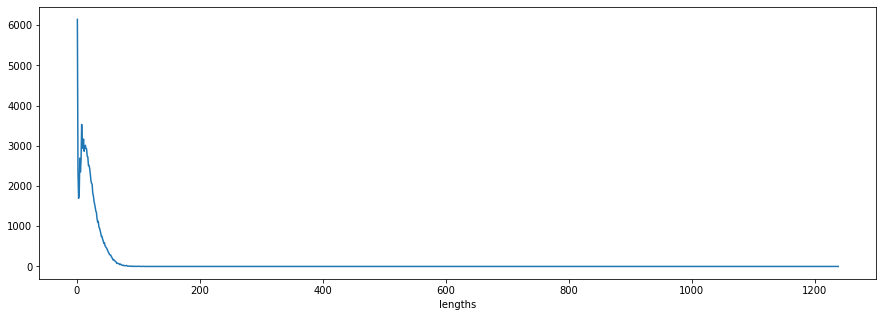

In [6]:
#lengths chart
df['lengths'] = lengths
print(df['lengths'].describe())
lengths_count = df.groupby('lengths').size()

print(lengths_count.head(5))
lengths_count.plot(figsize=(15,5))

In [7]:
#lengths chart
tags_df=pd.DataFrame(all_tags)
tags_df=tags_df.groupby(tags_df[0]).size()
tags_df.plot.bar(figsize=(15,5))

<AxesSubplot:xlabel='0'>

ValueError: 
PP$$
  ^
Expected end of text, found '$'  (at char 2), (line:1, col:3)

<Figure size 1080x360 with 1 Axes>

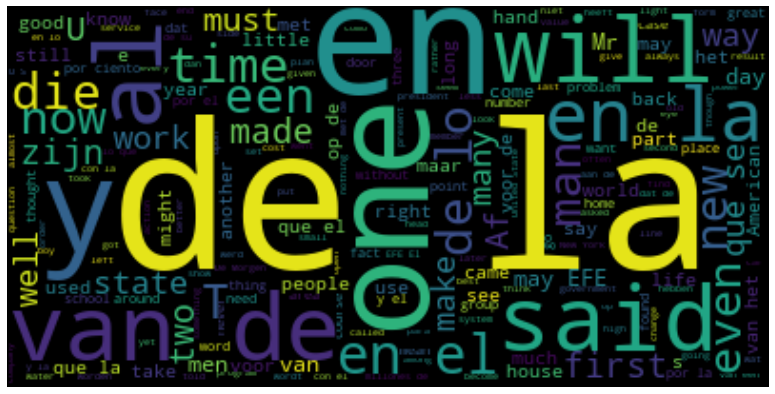

In [8]:
# Create and generate a word cloud image:
compine_string=(" ").join(all_words)

wordcloud = WordCloud().generate(compine_string)

# Display the generated image:
plt.figure(figsize = (20,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

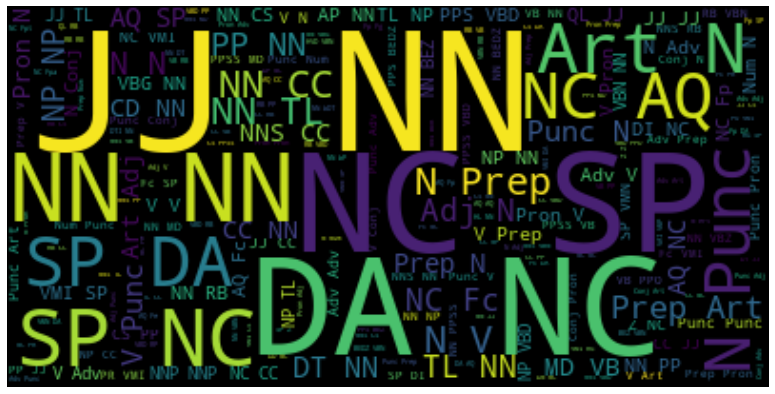

In [9]:
# Create and generate a word cloud image:
compine_string=(" ").join(all_tags)

wordcloud = WordCloud().generate(compine_string)

# Display the generated image:
plt.figure(figsize = (20,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:

x_tokenizer  = keras.preprocessing.text.Tokenizer(
    num_words=len(all_words_df),
lower=False,#False because in POS capitalization matters 
)
x_tokenizer.fit_on_texts(X)
X_sequences = x_tokenizer.texts_to_sequences(X)

#Y_categorical = keras.utils.to_categorical(Y)


y_tokenizer  = keras.preprocessing.text.Tokenizer(
lower=False,
)
y_tokenizer.fit_on_texts(Y)
Y_sequences = y_tokenizer.texts_to_sequences(Y)
print(f"print(texts_to_sequences) {Y_sequences[2]}")

In [ ]:
#No preprocessing since all tags are important in POS tagging

#vectorization

vectorizer = CountVectorizer()
#X_CountVectorizer = vectorizer.fit_transform(x_tokenized)


In [ ]:
#padding
PADDING_SIZE=50
X_padded = keras.preprocessing.sequence.pad_sequences(
    X_sequences,maxlen=PADDING_SIZE,padding='post',truncating='post')
Y_padded = keras.preprocessing.sequence.pad_sequences(
    Y_sequences,maxlen=PADDING_SIZE,padding='post',truncating='post')
print(X_padded.shape)
print(Y_padded.shape)
print(Y_padded[2])
Y_padded = keras.utils.to_categorical(Y_padded)
Y_padded.shape

In [ ]:
#split into train,val,test
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y_padded, test_size=0.1, random_state=42)

In [ ]:
#many-to-many RNN , sequence to sequence
model = keras.Sequential()

#model.add( keras.layers.Input( shape= (32,50,) ) )
model.add(
keras.layers.Embedding(
input_dim=len(all_words_df),
    output_dim=256,
    input_length=PADDING_SIZE,
)
)

model.add( keras.layers.SimpleRNN(128,return_sequences=True))

model.add(keras.layers.TimeDistributed(
    keras.layers.Dense(47, activation='softmax')
)) #2D output
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


In [ ]:
model.fit(x=X_train,y=Y_train,batch_size=32,epochs=15,validation_split=0.1)

In [ ]:
results=model.evaluate(X_test,Y_test,batch_size=32)
print(results)